In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import yaml
import pypsa

from pypsa.descriptors import Dict
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

from cartopy import crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from geopandas.tools import geocode

from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import calendar
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

### Load scenario and data

In [4]:
def load_configuration(config_path):
    """
    Load configuration settings from a YAML file.
    """
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    return config


snakemake = Dict()
snakemake.config = load_configuration("../config.yaml")
snakemake.input = Dict()
snakemake.output = Dict()

run = "DKDEPT-1H-allflex-noexcess-nocostshifts-manysteps"  # run name from config.yaml
distance = snakemake["config"]["scenario"]["distance"][0]  # pair name from config.yaml

if True:
    folder = f"/results/{run}"
    scenario = f"/2025/p1/cfe100/{distance}"

    snakemake.input.data = f"{folder}/networks/{scenario}/{distance}/40.nc"
    snakemake.output.plot = f"../manuscript/images/dashboard.pdf"

    n = pypsa.Network(f"../{folder}/networks/{scenario}/40.nc")

INFO:pypsa.io:Imported network 40.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [5]:
datacenters = snakemake.config["ci"][f"{distance}"]["datacenters"]
locations = list(datacenters.keys())
names = list(datacenters.values())

regions = gpd.read_file("../input/regions_onshore_elec_s_256.geojson")
n_256 = pypsa.Network("../input/elec_s_256_ec.nc")

df = pd.read_csv(f"..{folder}/csvs{scenario}/summary.csv", index_col=0, header=[0, 1])

INFO:pypsa.io:Imported network elec_s_256_ec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


In [6]:
# Wildcards & Settings
config = snakemake.config
policy = "cfe100"
palette = "p1"
zone = snakemake.config["zone"]
year = "2025"
datacenters = config["ci"][f"{distance}"]["datacenters"]
locations = list(datacenters.keys())
names = list(datacenters.values())

flexibilities = snakemake.config["scenario"]["flexibility"]

# techs for CFE hourly matching, extracted from palette
palette_techs = (
    ["onwind", "solar"],
    ["battery"],
    ["battery charger"],
    ["battery discharger"],
)

(
    clean_techs,
    storage_techs,
    storage_charge_techs,
    storage_discharge_techs,
) = palette_techs

# renaming technologies for plotting
clean_chargers = [tech.replace(" ", "_") for tech in storage_charge_techs]
clean_dischargers = [tech.replace(" ", "_") for tech in storage_discharge_techs]

In [7]:
rename_ci_capacity = pd.Series(
    {
        "onwind": "onshore wind",
        "solar": "solar",
        "battery_discharger": "battery",
        "H2_Fuel_Cell": "hydrogen fuel cell",
        "H2_Electrolysis": "hydrogen electrolysis",
        "adv_geothermal": "advanced dispatchable",
        "allam_ccs": "NG-Allam",
    }
)

rename_scen = {
    "0": "0%\n",
    "10": "10%\n",
    "20": "20%\n",
    "30": "30%\n",
    "40": "40%\n",
}

preferred_order = pd.Index(
    [
        "advanced dispatchable",
        "NG-Allam",
        "Gas OC",
        "offshore wind",
        "onshore wind",
        "solar",
        "battery",
        "hydrogen storage",
        "hydrogen electrolysis",
        "hydrogen fuel cell",
    ]
)

rename_ci_cost = pd.Series(
    {
        "onwind": "onshore wind",
        "solar": "solar",
        "grid": "grid imports",
        "revenue": "revenue",
        "battery_storage": "battery",
        "battery_inverter": "battery",
        "battery_discharger": "battery",
        "hydrogen_storage": "hydrogen storage",
        "hydrogen_electrolysis": "hydrogen storage",
        "hydrogen_fuel_cell": "hydrogen storage",
        "adv_geothermal": "advanced dispatchable",
        "allam_ccs": "NG-Allam",
    }
)

rename = {
    f"{name} {suffix}": category
    for name in names
    for suffix, category in {
        "H2 Electrolysis": "hydrogen storage",
        "H2 Fuel Cell": "hydrogen storage",
        "battery charger": "battery storage",
        "battery discharger": "battery storage",
        "export": "grid",
        "import": "grid",
        "onwind": "wind",
        "solar": "solar",
        "load": "load",
        "adv_geothermal": "clean dispatchable",
        "allam_ccs": "NG-Allam",
        "DSM-delayout": "temporal shift",
        "DSM-delayin": "temporal shift",
    }.items()
}

In [8]:
tech_colors = snakemake.config["tech_colors"]

### Plots to be used in the dashboard


In [9]:
### Plot 1


def assign_location(n):
    """
    Assign bus location per each individual component
    """
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue
            names = ifind.index[ifind == i]
            c.df.loc[names, "location"] = names.str[:i]


def plot_datacenters_on_europe_map(ax, network, datacenters):

    projection = ccrs.PlateCarree()
    # fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": projection})

    ax.set_extent([-15, 30, 30, 70], crs=ccrs.PlateCarree())

    map_opts = {
        "color_geomap": {
            "ocean": "lightblue",
            "land": "white",
            "border": "black",
            "coastline": "black",
        },
    }

    # Add map features with custom styles
    ax.add_feature(
        cfeature.OCEAN.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["ocean"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.LAND.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["land"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.BORDERS.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["border"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )
    ax.add_feature(
        cfeature.COASTLINE.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["coastline"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )

    n = network.copy()
    assign_location(n)

    n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)
    n.stores.drop(n.stores[n.stores.index.str.contains("EU")].index, inplace=True)
    n.links.drop(n.links[n.links.carrier == "dsm"].index, inplace=True)

    dc_locations = n.buses.loc[datacenters.keys(), ["x", "y"]]

    ax.scatter(
        dc_locations["x"],
        dc_locations["y"],
        color="darkblue",
        # label="Datacenter locations",
        transform=ccrs.Geodetic(),
        zorder=5,
        s=100,
    )
    ax.set_title("Datacenter locations", fontsize=14)

    connections = set()
    for i, loc1 in dc_locations.iterrows():
        for j, loc2 in dc_locations.iterrows():
            if i < j:  # each pair is considered only once
                ax.plot(
                    [loc1["x"], loc2["x"]],
                    [loc1["y"], loc2["y"]],
                    color="darkblue",
                    linestyle="dotted",
                    alpha=0.8,
                    transform=ccrs.Geodetic(),
                    zorder=4,
                    linewidth=2,
                )

    # Customize the plot
    plt.legend(loc="lower left")

    # fig.tight_layout()
    # fig.savefig(
    #     snakemake.output.plot_DC,
    #     facecolor="white",
    #     dpi=600,
    # )

In [10]:
### Plots 2 and 3


def plot_average_capacity_factor(ax, regions, network, carrier):

    if carrier == "onwind":
        colormap = "viridis"
    if carrier == "solar":
        colormap = "cividis"

    # Extract time series of specified carrier feed-in per region and calculate average
    carrier_data = network.generators_t.p_max_pu.filter(like=carrier).mean()

    # Adjust the renaming to include the full region and sub-region code
    capacity_factors = carrier_data.rename(lambda x: " ".join(x.split()[:-1])).to_frame(
        "average_capacity_factor"
    )

    # Merge using the updated keys
    regions = regions.merge(
        capacity_factors, left_on="name", right_index=True, how="left"
    )

    # fig, ax = plt.subplots(
    #     subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 8)
    # )
    ax.set_extent([-15, 30, 35, 60], crs=ccrs.PlateCarree())

    map_opts = {
        "color_geomap": {
            "ocean": "lightblue",
            "land": "white",
            "border": "black",
            "coastline": "black",
        },
    }

    # Add map features with custom styles
    ax.add_feature(
        cfeature.OCEAN.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["ocean"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.LAND.with_scale("50m"),
        facecolor=map_opts["color_geomap"]["land"],
        zorder=0,
    )
    ax.add_feature(
        cfeature.BORDERS.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["border"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )
    ax.add_feature(
        cfeature.COASTLINE.with_scale("50m"),
        edgecolor=map_opts["color_geomap"]["coastline"],
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )

    regions.plot(column="average_capacity_factor", ax=ax, legend=False, cmap=colormap)

    # Assuming 'average_capacity_factor' is normalized between min_val and max_val
    norm = mpl.colors.Normalize(
        vmin=regions["average_capacity_factor"].min(),
        vmax=regions["average_capacity_factor"].max(),
    )
    sm = mpl.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])  # You need this line for the colorbar to work with ScalarMappable.

    # Create colorbar
    cbar = ax.figure.colorbar(
        sm, ax=ax, orientation="horizontal", fraction=0.036, pad=0.01
    )

    if carrier == "onwind":
        _ = "onshore wind"
    if carrier == "solar":
        _ = "solar PV"

    ax.coastlines()
    ax.set_title(f"Annual average capacity factor for {_}", fontsize=14)
    # plt.show()


# plot_average_capacity_factor(regions, n, "onwind")

In [20]:
# plot 4


def format_column_names(col_tuple):
    return f"{col_tuple[0]}{col_tuple[1][:2]}"


def ci_capacity(
    ax, df, tech_colors, rename_scen, rename_ci_capacity, preferred_order, datacenters
):
    # fig, ax = plt.subplots(figsize=(8, 6))

    # Consolidate DataFrame operations
    inventory_frames = [
        df.loc[["ci_cap_" + t.replace(" ", "_") for t in techs]].rename(
            {"ci_cap_" + t: t for t in techs}
        )
        for techs in [clean_techs, clean_dischargers, clean_chargers]
    ]
    ldf = pd.concat(inventory_frames)
    ldf = ldf.drop(["battery_charger"])  # Exclude battery charger capacity

    # Drop rows with all values less ran 0.1
    ldf = ldf.drop(ldf.index[(ldf < 0.1).all(axis=1)])

    # Rename columns and indices, and reorder DataFrame
    ldf.rename(columns=rename_scen, level=0, inplace=True)
    ldf.rename(index=rename_ci_capacity, level=0, inplace=True)
    new_index = preferred_order.intersection(ldf.index).append(
        ldf.index.difference(preferred_order)
    )
    ldf = ldf.loc[new_index].sort_index(
        axis="columns", level=[1, 0], ascending=[False, True]
    )

    # Plotting
    if not ldf.empty:
        ldf.T.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            color=tech_colors,
            width=0.65,
            edgecolor="black",
            linewidth=0.05,
        )
        ax.set_xticklabels(
            [format_column_names(col) for col in ldf.columns.tolist()], fontsize=14
        )
        plt.xticks(rotation=0)
        ax.grid(alpha=0.3)
        ax.set_axisbelow(True)
        ax.set_ylim([0, max(ldf.sum()) * 1.3])
        ax.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
        ax.set_title("Portfolio capacity for 24/7 CFE matching", fontsize=14)
        ax.set_ylabel("Procured capacity [MW]", fontsize=14)
        ax.set_yticklabels(["{:,.0f}".format(x) for x in ax.get_yticks()], fontsize=14)
        ax.legend(loc="upper right", ncol=3, prop={"size": 12})

        # Add datacenter lines
        space = len(ldf.columns) / len(datacenters)
        for l in range(len(datacenters) - 1):
            ax.axvline(x=(space - 0.5) + space * l, color="gray", linestyle="--")
    else:
        print("Dataframe to plot is empty")

    # fig.tight_layout()
    # fig.savefig(snakemake.output.plot, transparent=True)


def ci_costandrev(
    ax, df, tech_colors, rename_scen, rename_ci_cost, preferred_order, datacenters
):
    # fig, ax = plt.subplots(figsize=(8, 6))

    # Define technologies list
    techs = clean_techs + [
        "grid",
        "battery_storage",
        "battery_inverter",
        "hydrogen_storage",
        "hydrogen_electrolysis",
        "hydrogen_fuel_cell",
    ]

    # Calculate costs and handle DataFrame operations
    costs = (
        df.loc[["ci_cost_" + t.replace(" ", "_") for t in techs]]
        .rename({"ci_cost_" + t: t for t in techs})
        .multiply(1 / df.loc["ci_demand_total"], axis=1)
    )
    costs = costs.drop(costs.index[(costs < 0.1).all(axis=1)])

    # Handling revenues
    revenues = -df.loc[["ci_average_revenue"]].rename({"ci_average_revenue": "revenue"})
    ldf = pd.concat([costs, revenues])

    # Rename and Group by rename_ci_cost, then sort
    ldf.rename(columns=rename_scen, level=0, inplace=True)
    ldf = ldf.groupby(rename_ci_cost).sum()
    new_index = ["onshore wind", "solar", "battery"]
    ldf = ldf.loc[new_index].sort_index(
        axis="columns", level=[1, 0], ascending=[False, True]
    )

    # Plotting
    if not ldf.empty:
        ldf.T.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            color=tech_colors,
            width=0.65,
            edgecolor="black",
            linewidth=0.05,
        )
        ax.set_xticklabels(
            [format_column_names(col) for col in ldf.columns.tolist()], fontsize=14
        )
        plt.xticks(rotation=0)
        ax.grid(alpha=0.3)
        ax.set_axisbelow(True)
        ax.set_ylabel("Normalised costs [€$\cdot$MWh$^{-1}$]", fontsize=14)
        ax.set_yticklabels(["{:,.0f}".format(x) for x in ax.get_yticks()], fontsize=14)
        ax.set_title("Costs of 24/7 CFE matching", fontsize=14)
        ax.legend(loc="upper left", ncol=3, prop={"size": 12})

        # # Add net cost markers
        # net_costs = ldf.sum()
        # for i, cost in enumerate(net_costs):
        #     ax.scatter(x=i, y=cost, color="black", marker="_")
        # ax.scatter([], [], color="black", marker="_", label="net cost")
        # ax.legend(loc="upper left", ncol=1, prop={"size": 12})

        # Add datacenter lines
        space = len(ldf.columns) / len(datacenters)
        for l in range(len(datacenters) - 1):
            ax.axvline(x=(space - 0.5) + space * l, color="gray", linestyle="--")
    else:
        print("Dataframe to plot is empty")

    # fig.tight_layout()
    # fig.savefig(
    #     snakemake.output.plot.replace("capacity.pdf", "ci_costandrev.pdf"),
    #     transparent=True,
    # )


def ci_abs_costs(ax, df, rename_scen):
    # fig, ax = plt.subplots(figsize=(6, 4.5))

    # Calculate absolute costs
    ldf = (df.loc["ci_total_cost"] - df.loc["ci_revenue_grid"]) / 1e6
    ldf = ldf.to_frame(name="ci_abs_costs")

    # Refine data
    ldf.index = ldf.index.set_levels(ldf.index.levels[0].map(rename_scen), level=0)
    ldf = ldf["ci_abs_costs"].unstack()
    ldf.sort_index(axis="rows", ascending=True, inplace=True)

    # Update columns for plotting
    ldf.columns = [format_column_names(col) for col in ldf.columns.tolist()]

    # Get the 'viridis' colormap
    cmap = plt.get_cmap("viridis")
    colors = [cmap(i) for i in np.linspace(0, 1, len(ldf.columns))]

    # Plotting
    if not ldf.empty:
        ldf.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            width=0.65,
            edgecolor="black",
            linewidth=0.05,
            color=colors,
        )
        plt.xticks(rotation=0)
        ax.grid(alpha=0.3)
        ax.set_axisbelow(True)

        # Additional calculations and horizontal lines
        value = ldf.sum(axis=1)[0] - ldf.sum(axis=1)[-1]
        percent_reduction = int(round(value / ldf.sum(axis=1)[0] * 100, 0))
        ax.set_title(f"Total annual costs reduction with flexibility", fontsize=14)
        for y_val in ldf.sum(axis=1):
            ax.hlines(
                y_val,
                ax.get_xlim()[0],
                ax.get_xlim()[1],
                color="gray",
                linestyle="--",
                linewidth=1.5,
                alpha=0.8,
            )

        ax.set_ylabel("Total annual costs [M€$\cdot$year$^{-1}$]", fontsize=14)
        ax.set_yticklabels(["{:,.0f}".format(x) for x in ax.get_yticks()], fontsize=14)
        ax.set_xticklabels(ldf.index, fontsize=14)
        ax.legend(loc="lower left", ncol=1, prop={"size": 12})

        # Add second y-axis for relative costs
        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        max_y_val = ldf.sum(axis=1)[0]
        ax2.set_yticks(np.linspace(0, max_y_val, 11))
        ax2.set_ylabel(f"Relative costs [%]", fontsize=14)
        vals = ax2.get_yticks()
        ax2.set_yticklabels(
            ["{:,.0%}".format(x / max_y_val) for x in vals], fontsize=14
        )

    else:
        print("Dataframe to plot is empty")

    # fig.tight_layout()
    # fig.savefig(
    #     snakemake.output.plot.replace("capacity.pdf", "ci_abs_costs.pdf"),
    #     transparent=True,
    # )

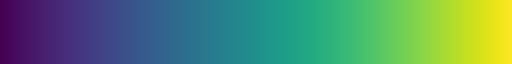

In [12]:
cmap = plt.get_cmap("viridis")
colors = [cmap(i) for i in np.linspace(0, 1, 5)]
cmap

In [13]:
# plots 7 to 12


def retrieve_nb(n, node):
    """
    Retrieve nodal energy balance per hour
        -> lines and links are bidirectional AND their subsets are exclusive.
        -> links include fossil gens
    NB {-1} multiplier is a nodal balance sign
    """

    components = ["Generator", "Load", "StorageUnit", "Store", "Link", "Line"]
    nodal_balance = pd.DataFrame(index=n.snapshots)

    for i in components:
        if i == "Generator":
            node_generators = n.generators.query("bus==@node").index
            nodal_balance = nodal_balance.join(n.generators_t.p[node_generators])
        if i == "Load":
            node_loads = n.loads.query("bus==@node").index
            nodal_balance = nodal_balance.join(-1 * n.loads_t.p_set[node_loads])
        if i == "Link":
            node_export_links = n.links.query("bus0==@node").index
            node_import_links = n.links.query("bus1==@node").index
            nodal_balance = nodal_balance.join(-1 * n.links_t.p0[node_export_links])
            nodal_balance = nodal_balance.join(-1 * n.links_t.p1[node_import_links])
            ##################
        if i == "StorageUnit":
            # node_storage_units = n.storage_units.query('bus==@node').index
            # nodal_balance = nodal_balance.join(n.storage_units_t.p_dispatch[node_storage_units])
            # nodal_balance = nodal_balance.join(n.storage_units_t.p_store[node_storage_units])
            continue
        if i == "Line":
            continue
        if i == "Store":
            continue

    nodal_balance = nodal_balance.rename(columns=rename).groupby(level=0, axis=1).sum()

    # Custom groupby function
    def custom_groupby(column_name):
        if column_name.startswith("vcc"):
            return "spatial shift"
        return column_name

    # Apply custom groupby function
    nodal_balance = nodal_balance.groupby(custom_groupby, axis=1).sum()

    # revert nodal balance sign for display
    if "spatial shift" in nodal_balance.columns:
        nodal_balance["spatial shift"] = nodal_balance["spatial shift"] * -1
    if "temporal shift" in nodal_balance.columns:
        nodal_balance["temporal shift"] = nodal_balance["temporal shift"] * -1

    return nodal_balance


def prepare_heatmap_shifts(shift_type, location, scaling):
    year = 2013
    data = (
        retrieve_nb(n, node=f"{location}").get(f"{shift_type}") * -1
    )  # NB REVERTING SIGN

    days = np.arange(1, 366)
    num_days = 365  # Correct number of days for a non-leap year
    values = np.empty((int(24 / scaling), num_days))
    values[:] = np.NaN  # Fill with NaNs as a default value

    for month in range(1, 13):
        month_data = data[data.index.month == month]
        for day in month_data.index.day.unique():
            day_idx = (
                sum([calendar.monthrange(year, m)[1] for m in range(1, month)])
                + day
                - 1
            )  # Adjusting day_idx to be zero-indexed
            day_values = month_data[month_data.index.day == day].values
            try:
                # Ensuring day_values is a 1D array before assignment
                values[:, day_idx] = day_values.squeeze()
            except ValueError as e:
                print(f"Error processing day {day} of month {month}: {e}")

    return days, values


def draw_heatmap(ax, day, value, scaling, colormap, min_val, max_val):
    xgrid = np.arange(day.max() + 1) + 1  # for days
    ygrid = np.arange(int(24 / scaling) + 1)  # for hours

    # Ensure the dimensions of 'value' match the expected dimensions for 'xgrid' and 'ygrid'
    if value.shape != (len(ygrid) - 1, len(xgrid) - 1):
        raise ValueError(
            f"Shape of value ({value.shape}) does not match xgrid ({len(xgrid)}) and ygrid ({len(ygrid)}) dimensions."
        )

    ax.pcolormesh(xgrid, ygrid, value, cmap=colormap, vmin=min_val, vmax=max_val)
    ax.set_ylim(int(24 / scaling), 0)
    ax.axis("off")


def add_custom_annotations(ax):

    ax.text(
        -0.005,
        0.25,
        "Hour of the Day",
        transform=ax.transAxes,
        rotation="vertical",
        ha="right",
        va="center",
        fontsize=14,
    )
    ax.text(
        0.1,
        -0.01,
        "Day of the Year",
        transform=ax.transAxes,
        ha="center",
        va="top",
        fontsize=14,
    )


def plot_heatmap_shifts(
    fig,
    ax,
    shift_type,
    location,
    scaling,
    colormap,
    min_val,
    max_val,
):
    # fig, axes = plt.subplots(1, 12, figsize=figsize, sharey=True)
    # plt.tight_layout()

    add_custom_annotations(ax)

    days, value = prepare_heatmap_shifts(shift_type, location, scaling)

    draw_heatmap(ax, days, value, scaling, colormap, min_val, max_val)

    ax.set_title(f"{location} - {shift_type} " + r"[MWh·h$^{-1}$]", fontsize=14, pad=3)

### Dashboard

/tmp/ipykernel_377882/3131005026.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["{:,.0f}".format(x) for x in ax.get_yticks()], fontsize=14)
/tmp/ipykernel_377882/3131005026.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["{:,.0f}".format(x) for x in ax.get_yticks()], fontsize=14)
/tmp/ipykernel_377882/3131005026.py:199: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["{:,.0f}".format(x) for x in ax.get_yticks()], fontsize=14)
/tmp/ipykernel_377882/1453187247.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


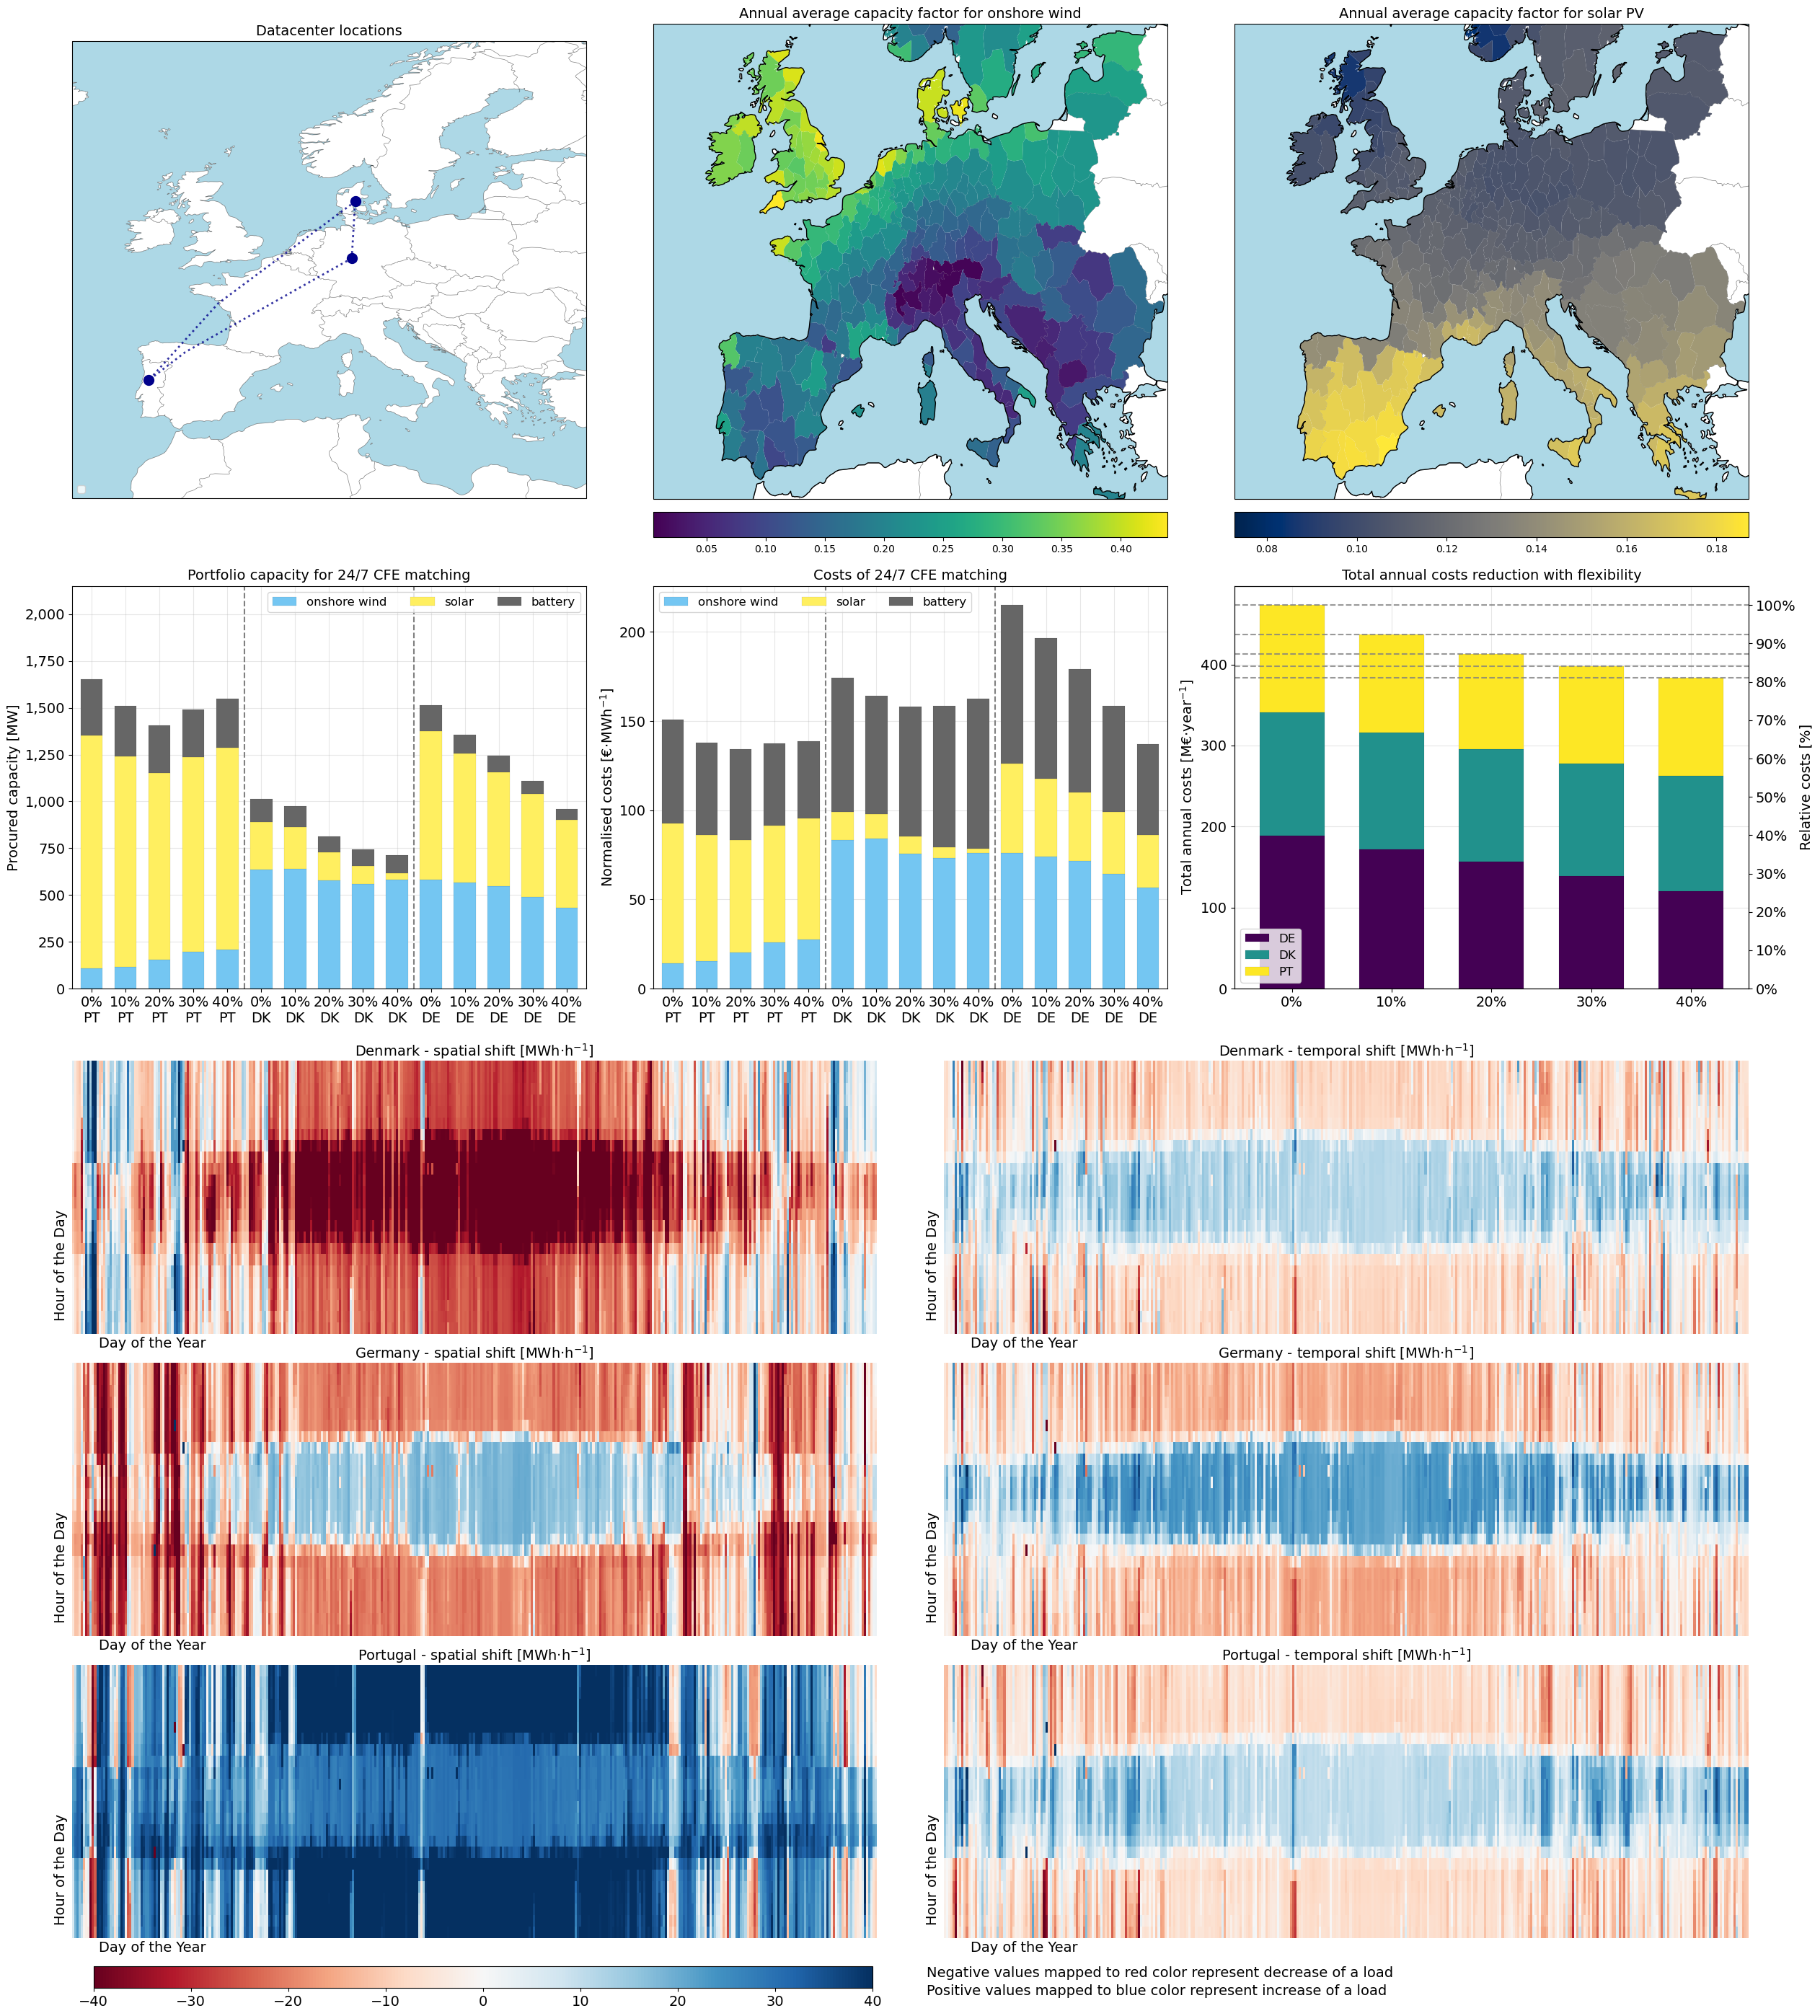

In [21]:
def create_dashboard(network, datacenters, regions, colormap):
    """
    Creates a dashboard for section 1: renewable resource quality
    """
    # Create figure
    # plt.figure(figsize=(30, 50))

    fig = plt.figure(figsize=(30, 50))

    # Define GridSpec: 5 rows, 6 columns
    gs = gridspec.GridSpec(65, 6, hspace=2, wspace=0.3)

    ax_map = plt.subplot(gs[16:30, :2], projection=ccrs.PlateCarree())
    plot_datacenters_on_europe_map(
        ax_map, network, datacenters
    )  # Custom function for the map

    ax_map = plt.subplot(gs[0:30, 2:4], projection=ccrs.PlateCarree())
    plot_average_capacity_factor(ax_map, regions, n_256, "onwind")

    ax_map = plt.subplot(gs[0:30, 4:6], projection=ccrs.PlateCarree())
    plot_average_capacity_factor(ax_map, regions, n_256, "solar")

    # Map plot
    ax_bar = plt.subplot(gs[30:40, :2])
    ci_capacity(
        ax=ax_bar,
        df=df,
        tech_colors=tech_colors,
        rename_scen=rename_scen,
        rename_ci_capacity=rename_ci_capacity,
        preferred_order=preferred_order,
        datacenters=datacenters,
    )

    ax_bar = plt.subplot(gs[30:40, 2:4])
    ci_costandrev(
        ax=ax_bar,
        df=df,
        tech_colors=tech_colors,
        rename_scen=rename_scen,
        rename_ci_cost=rename_ci_cost,
        preferred_order=preferred_order,
        datacenters=datacenters,
    )

    ax_bar = plt.subplot(gs[30:40, 4:6])
    ci_abs_costs(
        ax=ax_bar,
        df=df,
        rename_scen=rename_scen,
    )

    # # Map plot
    heatmap_ax_1 = plt.subplot(gs[41:48, 0:3])
    plot_heatmap_shifts(
        fig=fig,
        ax=heatmap_ax_1,
        shift_type="spatial shift",
        location="Denmark",
        scaling=1,
        colormap=colormap,
        min_val=-40.0,  # - int(flex)
        max_val=+40.0,  # + int(flex)
    )

    heatmap_ax_2 = plt.subplot(gs[41:48, 3:6])
    plot_heatmap_shifts(
        fig=fig,
        ax=heatmap_ax_2,
        shift_type="temporal shift",
        location="Denmark",
        scaling=1,
        colormap=colormap,
        min_val=-40.0,  # - int(flex)
        max_val=+40.0,  # + int(flex)
    )

    # # Map plot
    heatmap_ax_3 = plt.subplot(gs[48:55, 0:3])
    plot_heatmap_shifts(
        fig=fig,
        ax=heatmap_ax_3,
        shift_type="spatial shift",
        location="Germany",
        scaling=1,
        colormap=colormap,
        min_val=-40.0,  # - int(flex)
        max_val=+40.0,  # + int(flex)
    )

    heatmap_ax_4 = plt.subplot(gs[48:55, 3:6])
    plot_heatmap_shifts(
        fig=fig,
        ax=heatmap_ax_4,
        shift_type="temporal shift",
        location="Germany",
        scaling=1,
        colormap=colormap,
        min_val=-40.0,  # - int(flex)
        max_val=+40.0,  # + int(flex)
    )

    # # Map plot
    heatmap_ax_5 = plt.subplot(gs[55:62, 0:3])
    plot_heatmap_shifts(
        fig=fig,
        ax=heatmap_ax_5,
        shift_type="spatial shift",
        location="Portugal",
        scaling=1,
        colormap=colormap,
        min_val=-40.0,  # - int(flex)
        max_val=+40.0,  # + int(flex)
    )

    heatmap_ax_6 = plt.subplot(gs[55:62, 3:6])
    plot_heatmap_shifts(
        fig=fig,
        ax=heatmap_ax_6,
        shift_type="temporal shift",
        location="Portugal",
        scaling=1,
        colormap=colormap,
        min_val=-40.0,  # - int(flex)
        max_val=+40.0,  # + int(flex)
    )

    # Creating a colorbar specifically for the heatmap subplot

    cbar_ax = fig.add_axes(
        [0.135, 0.132, 0.36, 0.006]
    )  # These values may need adjustment
    norm = mc.Normalize(vmin=-40.0, vmax=+40.0)
    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap=colormap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.ax.tick_params(labelsize=14)

    fig.text(
        0.52,
        0.13,
        "Positive values mapped to blue color represent increase of a load",
        ha="left",
        fontsize=14,
    )

    fig.text(
        0.52,
        0.135,
        "Negative values mapped to red color represent decrease of a load",
        ha="left",
        fontsize=14,
    )

    # plt.show()
    fig.tight_layout()
    fig.savefig(
        "../manuscript/img/dashboard.pdf", transparent=True, bbox_inches="tight"
    )


create_dashboard(network=n, datacenters=datacenters, regions=regions, colormap="RdBu")